In [61]:
import numpy as np
import pandas as pd
import altair as alt
import string
import nltk
from nltk.stem import SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer



alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()
%matplotlib inline

In [2]:
disney_df = pd.read_csv("../data/raw/DisneylandReviews.csv")
reviews = disney_df['Review_Text']

In [3]:
reviews  

0        If you've ever been to Disneyland anywhere you...
1        Its been a while since d last time we visit HK...
2        Thanks God it wasn   t too hot or too humid wh...
3        HK Disneyland is a great compact park. Unfortu...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited Disneyland ...
42653    My eleven year old daughter and myself went to...
42654    This hotel, part of the Disneyland Paris compl...
42655    I went to the Disneyparis resort, in 1996, wit...
Name: Review_Text, Length: 42656, dtype: object

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('hk', 'hongkong')
    text = text.replace('hong kong', 'hongkong')
    text = text.replace("n't", " not")
    text = text.replace('n   t', " not")
    text = text.replace('disneyparis', 'disney paris')
    text = text.replace('kowlon', 'kowloon')
    text = text.replace('  ', ' ')
    return text

In [5]:
reviews = reviews.apply(lambda x: preprocess(x))
reviews

0        if you've ever been to disneyland anywhere you...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park. u...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel, part of the disneyland paris compl...
42655    i went to the disney paris resort, in 1996, wi...
Name: Review_Text, Length: 42656, dtype: object

In [6]:
def remove_punc(text):
    clean = ''.join([char for char in text if char not in string.punctuation])
    return clean

In [7]:
reviews = reviews.apply(lambda x: remove_punc(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around 1 ...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in 1996 with...
Name: Review_Text, Length: 42656, dtype: object

In [8]:
def remove_digit(text):
    clean = ''.join([i for i in text if not i.isdigit()])
    clean = clean.replace('  ', ' ')
    return clean

In [9]:
reviews = reviews.apply(lambda x: remove_digit(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around ho...
                               ...                        
42651    i went to disneyland paris in july and thought...
42652     adults and child of visited disneyland paris ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in with a sm...
Name: Review_Text, Length: 42656, dtype: object

In [10]:
# def spell_checker(text):
#     t = TextBlob(text)
#     spell_checked = ' '.join([w.correct() for w in t.words])
#     return spell_checked 

In [11]:
# spell_checked = reviews.apply(lambda x: spell_checker(x))
# spell_checked 

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

In [13]:
reviews_tokenized = reviews.apply(lambda x: tokenizer.tokenize(x.lower()))
reviews_tokenized 

0        [if, youve, ever, been, to, disneyland, anywhe...
1        [its, been, a, while, since, d, last, time, we...
2        [thanks, god, it, was, not, too, hot, or, too,...
3        [hongkong, disneyland, is, a, great, compact, ...
4        [the, location, is, not, in, the, city, took, ...
                               ...                        
42651    [i, went, to, disneyland, paris, in, july, and...
42652    [adults, and, child, of, visited, disneyland, ...
42653    [my, eleven, year, old, daughter, and, myself,...
42654    [this, hotel, part, of, the, disneyland, paris...
42655    [i, went, to, the, disney, paris, resort, in, ...
Name: Review_Text, Length: 42656, dtype: object

In [14]:
nltk_stopwords = pd.Series(stopwords.words("english"))
nltk_stopwords = nltk_stopwords.apply(lambda x: remove_punc(x))
nltk_stopwords = set(nltk_stopwords)

In [15]:
stopwords_700 = pd.read_csv('../EDA/stopwords.txt', header= None, delimiter = "\t")
stopwords_700 = set(stopwords_700[0])

In [16]:
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english"))
    stop_words_customize = {'disney', 'disneyland', 'land', 'park', 'parks', 'world', 'disneyworld', 'disney world', 'one'}
    stop_words_all = nltk_stopwords.union(stopwords_700, stop_words_customize)
    clean = [word for word in text if not word in stop_words_all]
    return clean

In [17]:
reviews_nostop = reviews_tokenized.apply(lambda x: remove_stopwords(x))

In [18]:
reviews_nostop

0        [find, hongkong, similar, layout, walk, street...
1        [last, time, visit, hongkong, time, stay, tomo...
2        [thanks, god, hot, humid, visiting, big, issue...
3        [hongkong, great, compact, unfortunately, bit,...
4        [location, city, took, hour, kowloon, kids, li...
                               ...                        
42651    [went, paris, july, thought, brilliant, visite...
42652    [adults, child, visited, paris, beginning, feb...
42653    [eleven, year, old, daughter, went, visit, son...
42654    [hotel, part, paris, complex, wonderful, place...
42655    [went, paris, resort, small, child, minute, en...
Name: Review_Text, Length: 42656, dtype: object

In [19]:
def pos_lemmatize(text):
    lem = WordNetLemmatizer()
    for word, tag in nltk.pos_tag(text):
        if tag.startswith("NN"):
            yield lem.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield lem.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield lem.lemmatize(word, pos='a')
        else:
            yield word

In [20]:
def final_lemmatizer(text):
    lem_text = ' '.join(pos_lemmatize(text))
    return lem_text

In [21]:
reviews_lemmatized = reviews_nostop.apply(lambda x: final_lemmatizer(x))
reviews_lemmatized

0        find hongkong similar layout walk street famil...
1        last time visit hongkong time stay tomorrowlan...
2        thanks god hot humid visit big issue shadei ar...
3        hongkong great compact unfortunately bit maint...
4        location city take hour kowloon kid like fine ...
                               ...                        
42651    go paris july think brilliant visited hotel st...
42652    adult child visited paris begin feb absolute f...
42653    eleven year old daughter go visit son london d...
42654    hotel part paris complex wonderful place famil...
42655    go paris resort small child minute enter trans...
Name: Review_Text, Length: 42656, dtype: object

In [22]:
stemmer = LancasterStemmer()

def text_stemmer(text):
    stem_text = ''.join([stemmer.stem(i) for i in text])
    return stem_text

In [23]:
reviews_clean = reviews_lemmatized.apply(lambda x: text_stemmer(x))
reviews_clean

0        find hongkong similar layout walk street famil...
1        last time visit hongkong time stay tomorrowlan...
2        thanks god hot humid visit big issue shadei ar...
3        hongkong great compact unfortunately bit maint...
4        location city take hour kowloon kid like fine ...
                               ...                        
42651    go paris july think brilliant visited hotel st...
42652    adult child visited paris begin feb absolute f...
42653    eleven year old daughter go visit son london d...
42654    hotel part paris complex wonderful place famil...
42655    go paris resort small child minute enter trans...
Name: Review_Text, Length: 42656, dtype: object

In [24]:
reviews_clean[0:10]

0    find hongkong similar layout walk street famil...
1    last time visit hongkong time stay tomorrowlan...
2    thanks god hot humid visit big issue shadei ar...
3    hongkong great compact unfortunately bit maint...
4    location city take hour kowloon kid like fine ...
5    anaheim tokyo feel hongkong small call way rid...
6    great place day wo know obviously go daughter ...
7    think intro magic little one attraction comple...
8    feel let placethe train fantastic past station...
9    talk say childhood dream come true start entra...
Name: Review_Text, dtype: object

### embeddings

In [25]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(reviews_clean[0:10000], show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [26]:
embeddings

array([[-0.6975749 , -0.13643305,  0.9038483 , ...,  0.85246605,
        -0.5135764 , -0.22898293],
       [-0.421778  ,  0.02271531,  0.6387496 , ...,  0.14367424,
         0.28712925, -0.7671961 ],
       [-0.28219888,  0.10791975,  0.98113585, ...,  0.12422124,
        -0.27820262, -0.4483604 ],
       ...,
       [-0.33452088, -0.48336244,  1.0795755 , ..., -0.21132454,
         0.01214098, -0.76798797],
       [-0.06199561,  0.17828819,  1.0447465 , ...,  0.21801765,
        -0.49830344, -1.3235809 ],
       [-0.8040637 , -0.39871413,  1.0468129 , ...,  0.26616812,
         0.22603197, -0.31997895]], dtype=float32)

In [27]:
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [28]:
umap_embeddings

array([[14.101172 , -3.5529213, 14.785128 ,  3.4090052, 12.00718  ],
       [16.564814 , -5.6741633, 14.910553 ,  4.4259872, 12.250204 ],
       [16.991705 , -4.982561 , 15.591683 ,  2.6467412, 11.598336 ],
       ...,
       [15.5799885, -4.417941 , 15.257003 ,  3.7563746, 11.608385 ],
       [14.363771 , -3.8922734, 15.619446 ,  3.3129487, 11.270508 ],
       [15.438481 , -5.644741 , 15.284159 ,  3.3205376, 10.579744 ]],
      dtype=float32)

In [40]:
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                           metric='euclidean',                      
                           cluster_selection_method='eom').fit(umap_embeddings)

In [41]:
result

,x,y,labels
0,10.442847,1.904368,1
1,14.714104,-0.069682,1
2,13.545857,1.598360,1
3,13.977159,3.198303,1
4,10.631547,1.313774,1
...,...,...,...
9995,12.925479,-0.082248,1
9996,13.466598,2.806940,1
9997,12.347876,0.654869,-1
9998,10.293548,0.648338,1


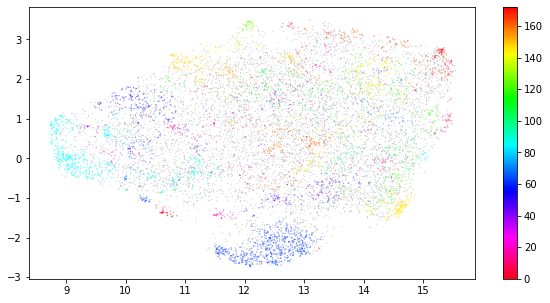

In [44]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [65]:
doc = pd.DataFrame(reviews_clean[0:10000])
doc['Topic'] = cluster.labels_
doc['Doc_ID'] = range(len(doc))

In [66]:
doc

,Review_Text,Topic,Doc_ID
0,find hongkong similar layout walk street famil...,79,0
1,last time visit hongkong time stay tomorrowlan...,-1,1
2,thanks god hot humid visit big issue shadei ar...,130,2
3,hongkong great compact unfortunately bit maint...,-1,3
4,location city take hour kowloon kid like fine ...,-1,4
...,...,...,...
9995,truly magical place christmas enhances experie...,154,9995
9996,delight join folk experience extraordinary tim...,106,9996
9997,visitied day fine weather go decemberhowever v...,-1,9997
9998,far happy place earth sure long line high pric...,-1,9998


In [59]:
docs_per_topic = doc.groupby(['Topic'], as_index = False).agg({'Review_Text': ' '.join})

In [62]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [67]:
tf_idf, count = c_tf_idf(docs_per_topic.Review_Text.values, m=len(reviews_clean[0:10000]))

In [70]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Review_Text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Review_Text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [71]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(doc); topic_sizes.head(10)

,Topic,Size
0,-1,6408
63,62,553
85,84,369
149,148,119
144,143,118
146,145,111
56,55,59
163,162,55
84,83,48
60,59,44


### LDA

In [73]:
data = doc.Review_Text.values.tolist()